### Шаг 3: Предварительныя обработка

In [1]:
# импортируем все нужные библиотеки и открываем наш датасет
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [2]:
df = pd.read_excel("cian_data.xlsx")
df.head(3)

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_month,commissions,district,street,house_number,underground,residential_complex
0,Циан х ПИК-Аренда,real_estate_agent,https://www.cian.ru/rent/flat/300913633/,Москва,rent,flat,12,17,3,72.7,88000,0,Черемушки,Наметкина,11,Новые Черёмушки,NaN
1,АЛЬФА,real_estate_agent,https://www.cian.ru/rent/flat/301061437/,Москва,rent,flat,24,25,2,65.0,110000,0,Обручевский,Ленинский проспект,105к3,Новаторская,NaN
2,ID 103272859,homeowner,https://www.cian.ru/rent/flat/301856867/,Москва,rent,flat,4,5,2,37.0,40000,0,Марфино,Гостиничный проезд,6К2,Окружная,NaN


из-за некоторых приколов с парсером, в нашем датасете есть дубликаты, поэтому сразу от них избавляемся

In [3]:
print("Всего наблюдений в датасете:", df.shape[0])
print("Уникальных значений в датасете:", len(df['url'].unique()))

Всего наблюдений в датасете: 3185
Уникальных значений в датасете: 1469


In [4]:
df = df.drop_duplicates('url')
df.shape[0]

1469

Отлично. Теперь посмотрим на распределения численных столбцов

In [5]:
print("Всего численных столбцов в датасете: ", len(df.select_dtypes(exclude='object').columns))

Всего численных столбцов в датасете:  6


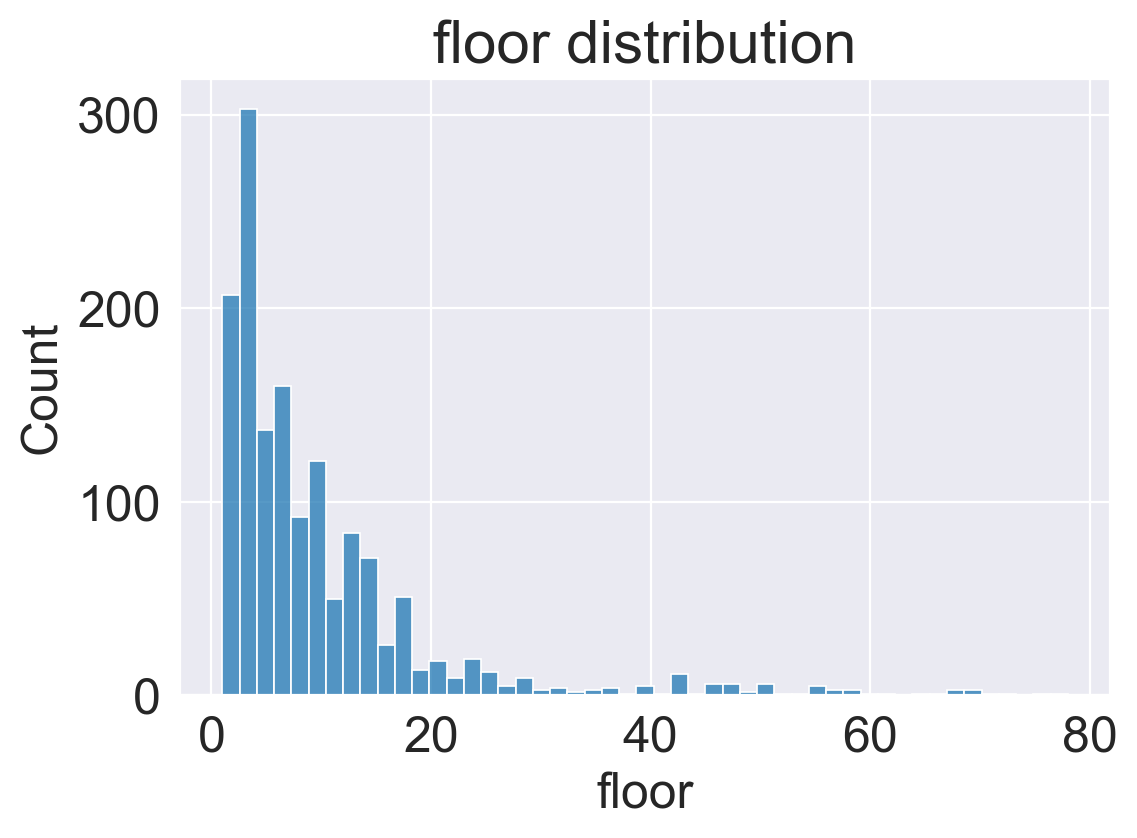

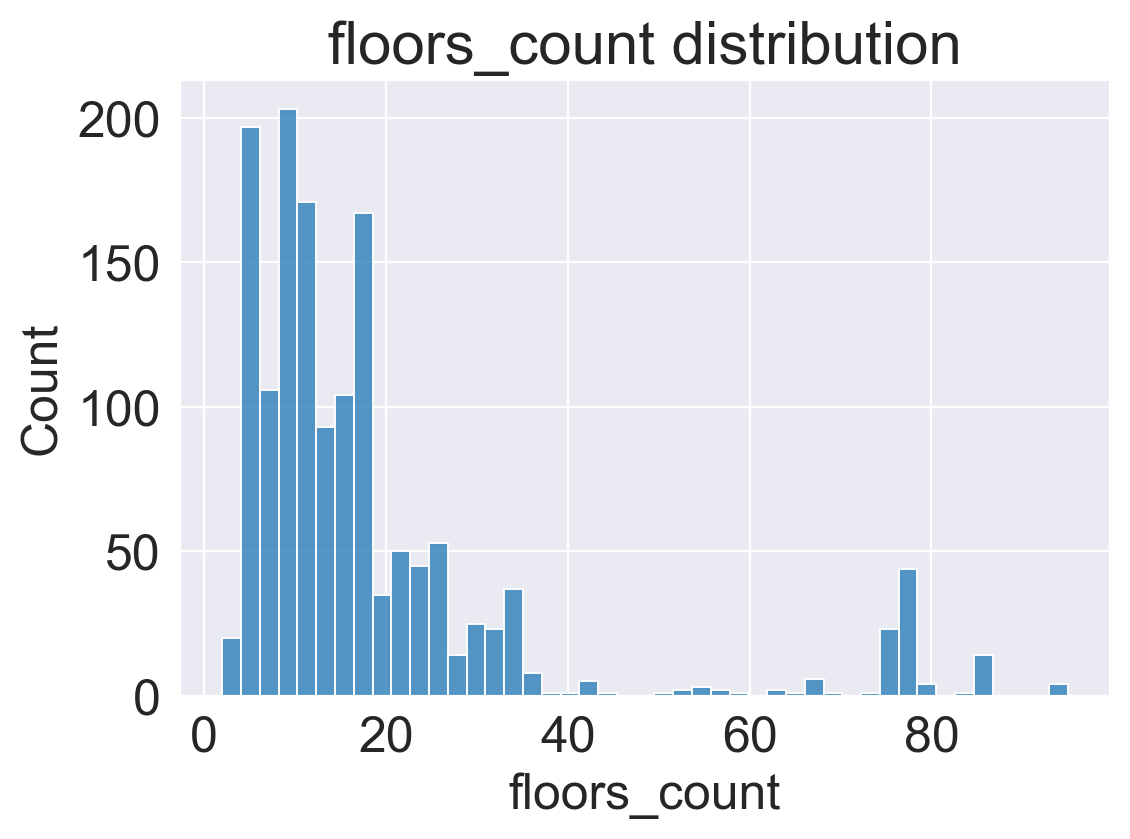

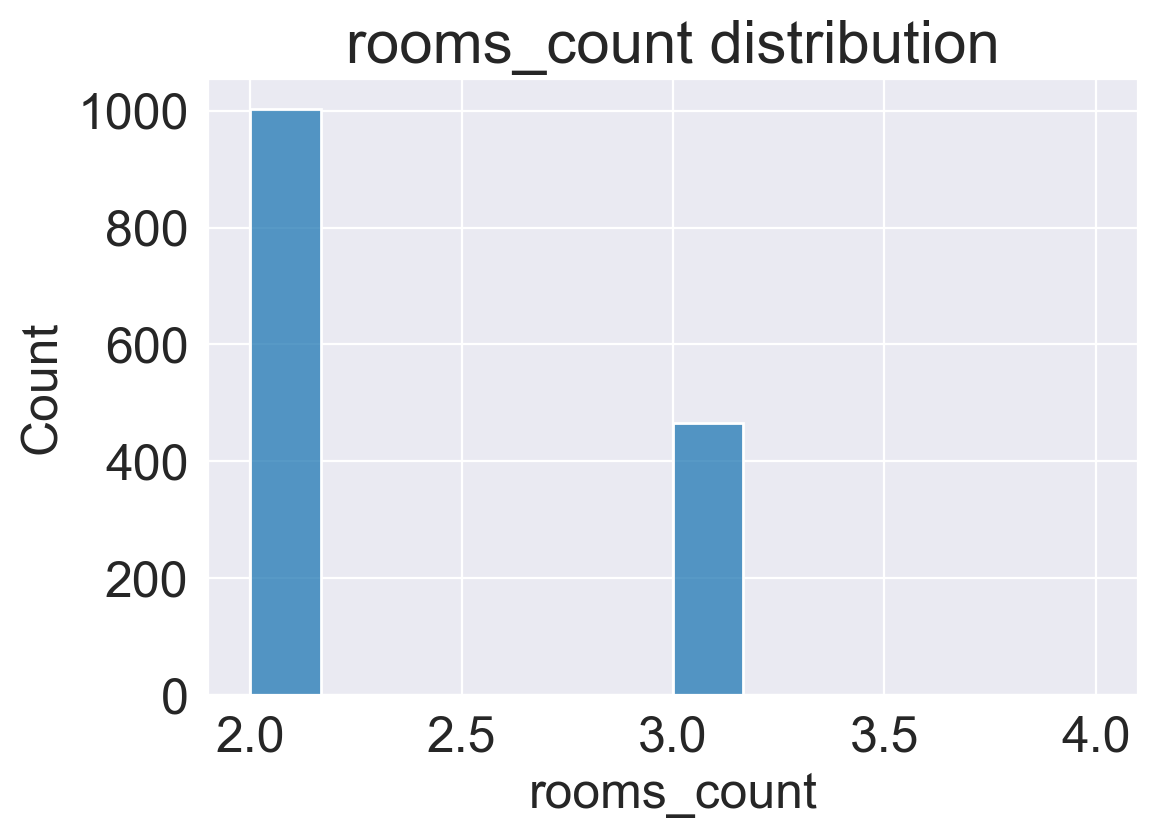

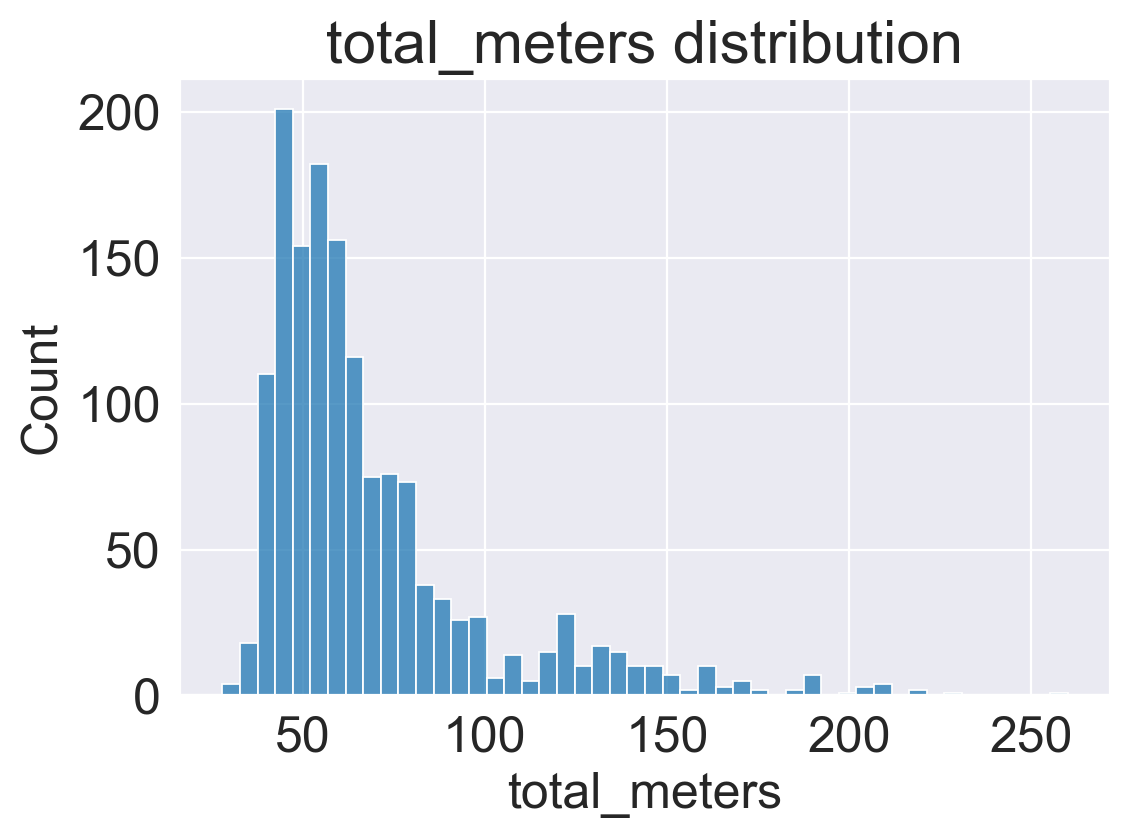

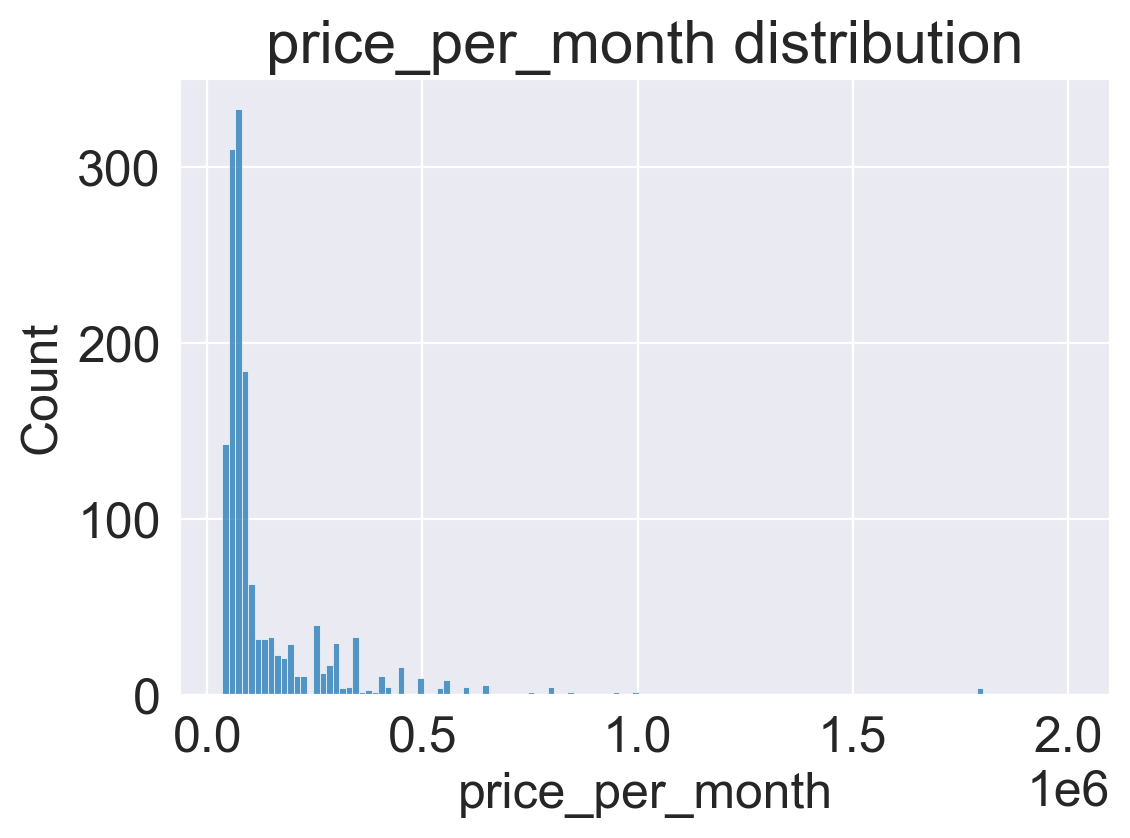

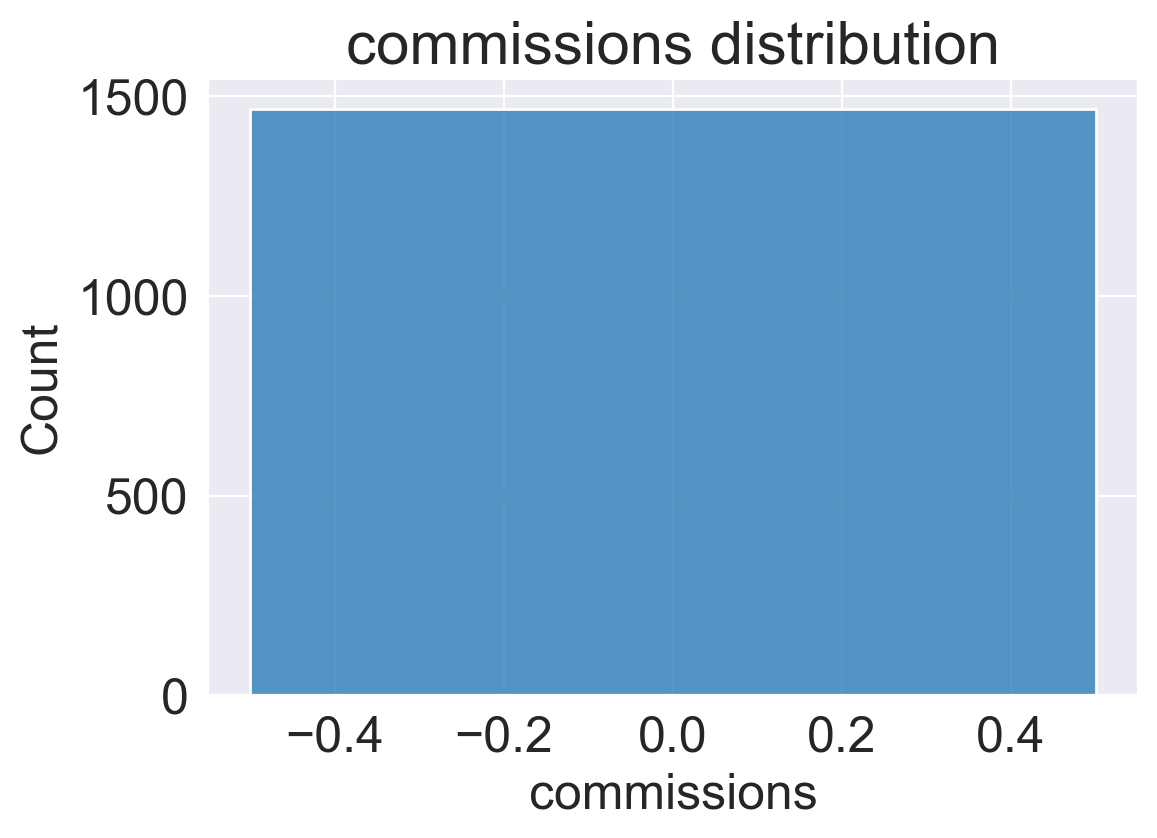

In [6]:
for col in df.select_dtypes(exclude='object').columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col])
    plt.title(f'{col} distribution')
    plt.show()

Видим, что в столбце price_per_month есть явные выбросы. Проверим это еще одним способом:

In [7]:
df['price_per_month'].agg(['mean', 'median', 'max'])

mean      1.437879e+05
median    8.000000e+04
max       2.000000e+06
Name: price_per_month, dtype: float64

Среднее значение в районе 150ти тысяч, медиана в районе 80ти тысяч, а максимальное значение же около двух миллионов. Очистим датасет по этому столбцу используя IQR:

In [8]:
def is_float(string):
    """
    Немного доработанная функция .isnumeric(), которая принимает на вход строку
    и проверяет является ли эта строка положительным вещественным числом
    """
    if string.replace(".", "").replace(',', '').isnumeric():
        return True
    else:
        return False

In [9]:
def mark_outliers(series: pd.Series):
    """
    Функция принимает объект Series на вход
    и возвращает новую Series в которой содержатся только булевые значения.
    True означает что на данной позиции находится выброс, False - обратное.
    Для определения выброса используется методика IQR
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    return ~series.apply(lambda x: (lower_fence <= float(x) <= upper_fence
                                    if is_float(str(x)) else True))

In [10]:
print("Количество выбросов:", mark_outliers(df['price_per_month']).sum())

Количество выбросов: 191


In [11]:
df = df[~mark_outliers(df['price_per_month'])]
print("Итоговый размер датасета:", df.shape)

Итоговый размер датасета: (1278, 17)


In [12]:
df['price_per_month'].agg(['mean', 'median', 'max'])

mean       91774.892019
median     75000.000000
max       275471.000000
Name: price_per_month, dtype: float64

Отлично, теперь среднее почти (почти!) равнаяется медиане, а максимальное значение составляет всего 275 тысяч

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 0 to 1504
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               1278 non-null   object 
 1   author_type          1278 non-null   object 
 2   url                  1278 non-null   object 
 3   location             1278 non-null   object 
 4   deal_type            1278 non-null   object 
 5   accommodation_type   1278 non-null   object 
 6   floor                1278 non-null   int64  
 7   floors_count         1278 non-null   int64  
 8   rooms_count          1278 non-null   int64  
 9   total_meters         1278 non-null   float64
 10  price_per_month      1278 non-null   int64  
 11  commissions          1278 non-null   int64  
 12  district             1258 non-null   object 
 13  street               1278 non-null   object 
 14  house_number         1278 non-null   object 
 15  underground          1278 non-null   object

для начала удалим столбец residential_complex так как в нём нет ни одного значения кроме как NaN

In [14]:
df = df.drop("residential_complex", axis=1)

Теперь заполним значения NaN в столбце district. Так как это категориальный столбец, пропуски заполним строковым значением "NotGiven"

In [15]:
df['district'] = df['district'].fillna("NotGiven")

Взглянем на количество уникальных значений в каждом слобце:

In [16]:
max_lenght = max(len(col) for col in df.columns)
print("Количество уникальных значений в каждом столбце:")
for col in df.columns:
    count = len(df[col].unique())
    print(f'{col:<{max_lenght}} -> {count}')

Количество уникальных значений в каждом столбце:
author             -> 656
author_type        -> 5
url                -> 1278
location           -> 1
deal_type          -> 1
accommodation_type -> 1
floor              -> 47
floors_count       -> 54
rooms_count        -> 3
total_meters       -> 220
price_per_month    -> 127
commissions        -> 1
district           -> 111
street             -> 570
house_number       -> 495
underground        -> 240


Видим 4 столбца в которых всего 1 уникальное значение. Их тоже удалим

In [17]:
df = df.drop(['location', 'deal_type', 'accommodation_type', 'commissions'], axis=1)

### Шаг 4 и 5: Визуализация и создание новых признаков

In [18]:
df.sample(5)

,author,author_type,url,floor,floors_count,rooms_count,total_meters,price_per_month,district,street,house_number,underground
427,ЦАН,real_estate_agent,https://www.cian.ru/rent/flat/301887686/,13,22,2,62.0,80000,Лианозово,Алтуфьевское шоссе,85,Алтуфьево
1452,MY HOME,real_estate_agent,https://www.cian.ru/rent/flat/300990758/,3,17,2,55.0,90000,Крылатское,Осенний бульвар,10К2,Крылатское
1072,Валерия Левина,realtor,https://www.cian.ru/rent/flat/301398572/,15,16,2,53.0,65000,Орехово-Борисово Северное,Каширское шоссе,94К2,Домодедовская
1296,Capital Mars,real_estate_agent,https://www.cian.ru/rent/flat/299142353/,11,25,2,84.0,80000,Митино,Пятницкое шоссе,15к1,Волоколамская
847,Светлана Бурлакова,realtor,https://www.cian.ru/rent/flat/290820030/,4,5,2,41.0,52000,Фили-Давыдково,Кременчугская,34К1,Давыдково


Для начала посмотрим на корреляцию между количественными переменными, дабы отсеить какие-то тривиальные зависимости и возможно найти что-то интересное для дальнейшего исследования

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

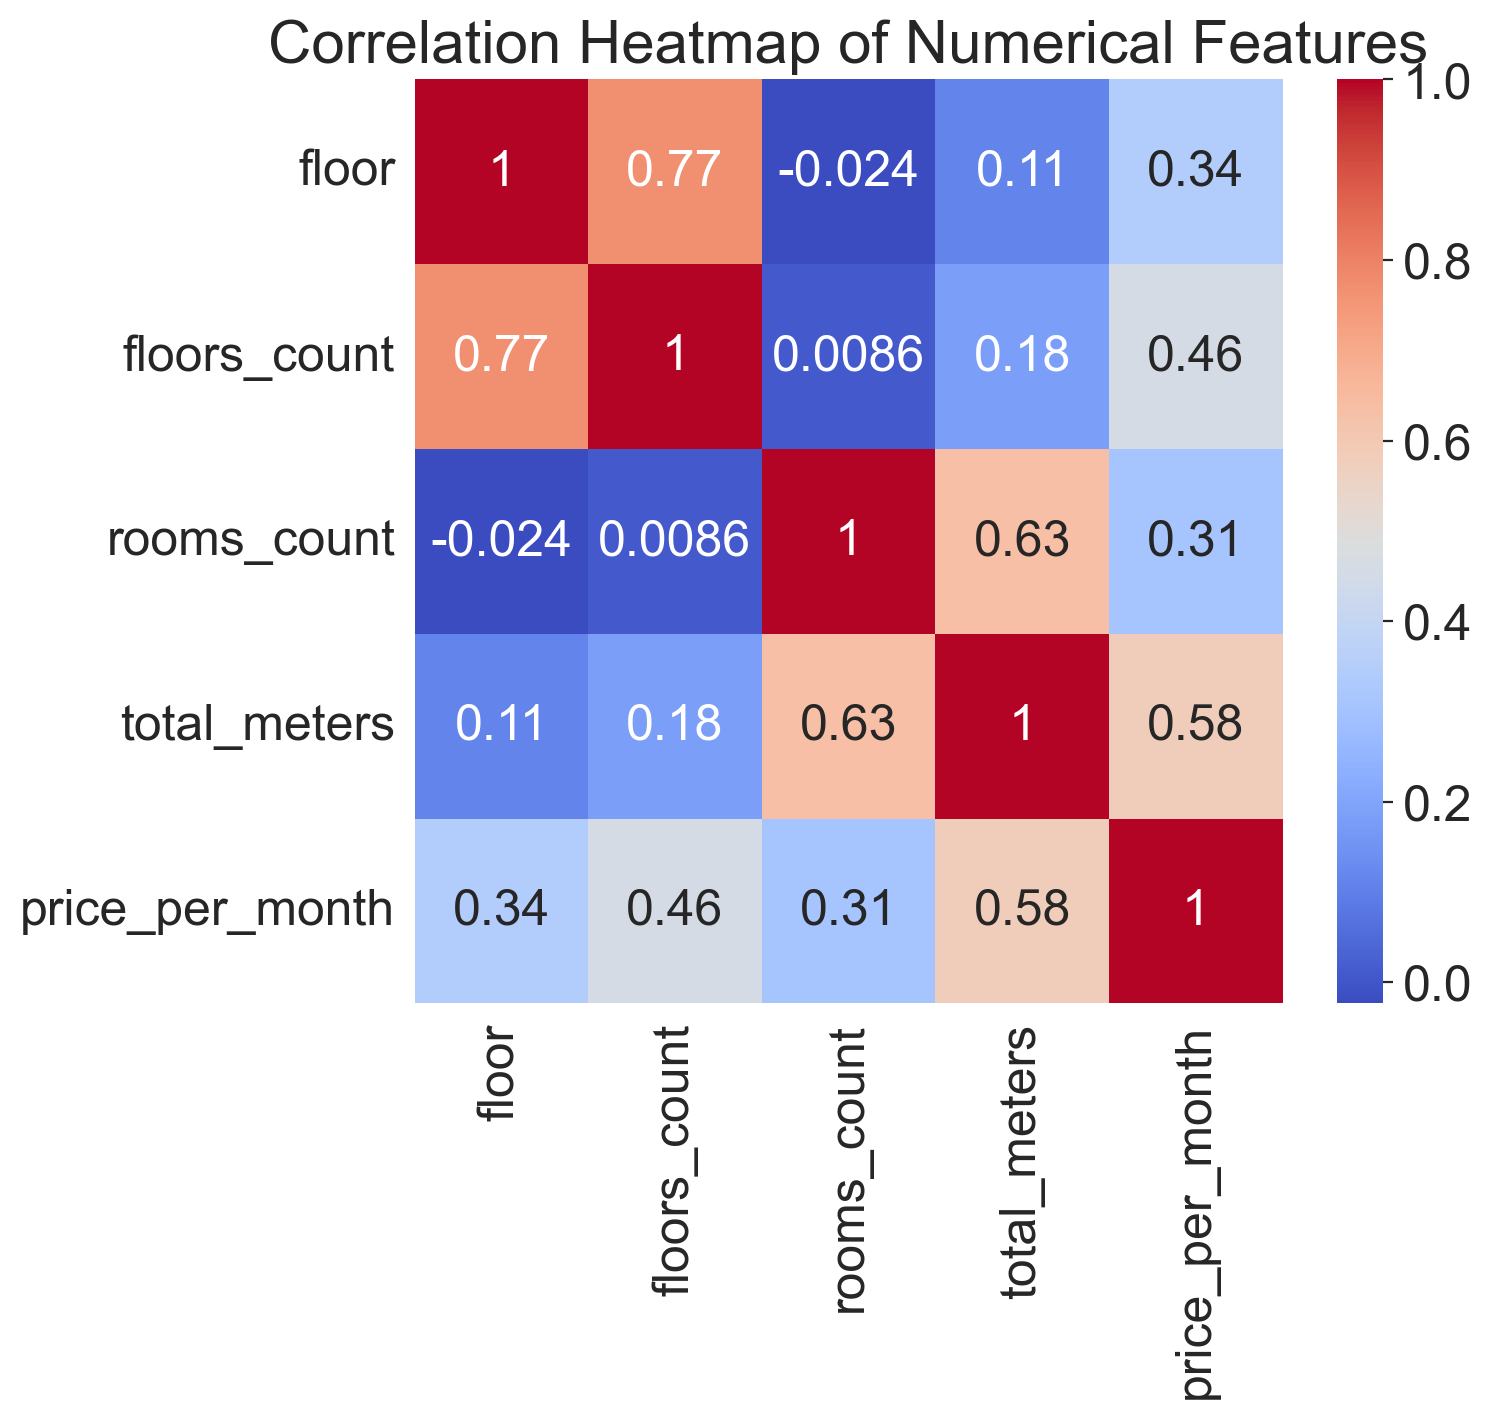

In [19]:
plt.figure(figsize=(7, 6))
sns.heatmap(df.select_dtypes(exclude="object").corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")

Сразу в глаза бросаются несколько зависимостей, и все они являются тривиальными:
1) Количество этажей в здании значимо коррелирует с этажом, на котором расположена квартира (коэфф. корреляции пирсона 0.77)
2) Количество метров в квартире значимо коррелирует с количеством комнат в этой квартире (коэфф. корреляции пирсона 0.63)
3) Количество метров в квартире значимо коррелирует с ценой (в месяц) данной квартиры (коэфф. корреляции пирсона 0.58)
4) Этаж квартиры а также количество комнат в ней значительно коррелируют с ценой (в месяц) данной квартиры (коэфф. корреляции пирсона 0.34 и 0.31 соответственно)


Однако есть еще одна значимая зависимость. И это корреляция между количеством этажей в здании и ценой квартиры. Она мне уже не кажется такой тривиальной как предыдущие 3. Предлагаю пока-что посмотреть на scatterplot и просто запомнить этот моментик (Спойлер: можно не запоминать =} )

Text(0.5, 1.0, 'Price per Month by Number of Floors')

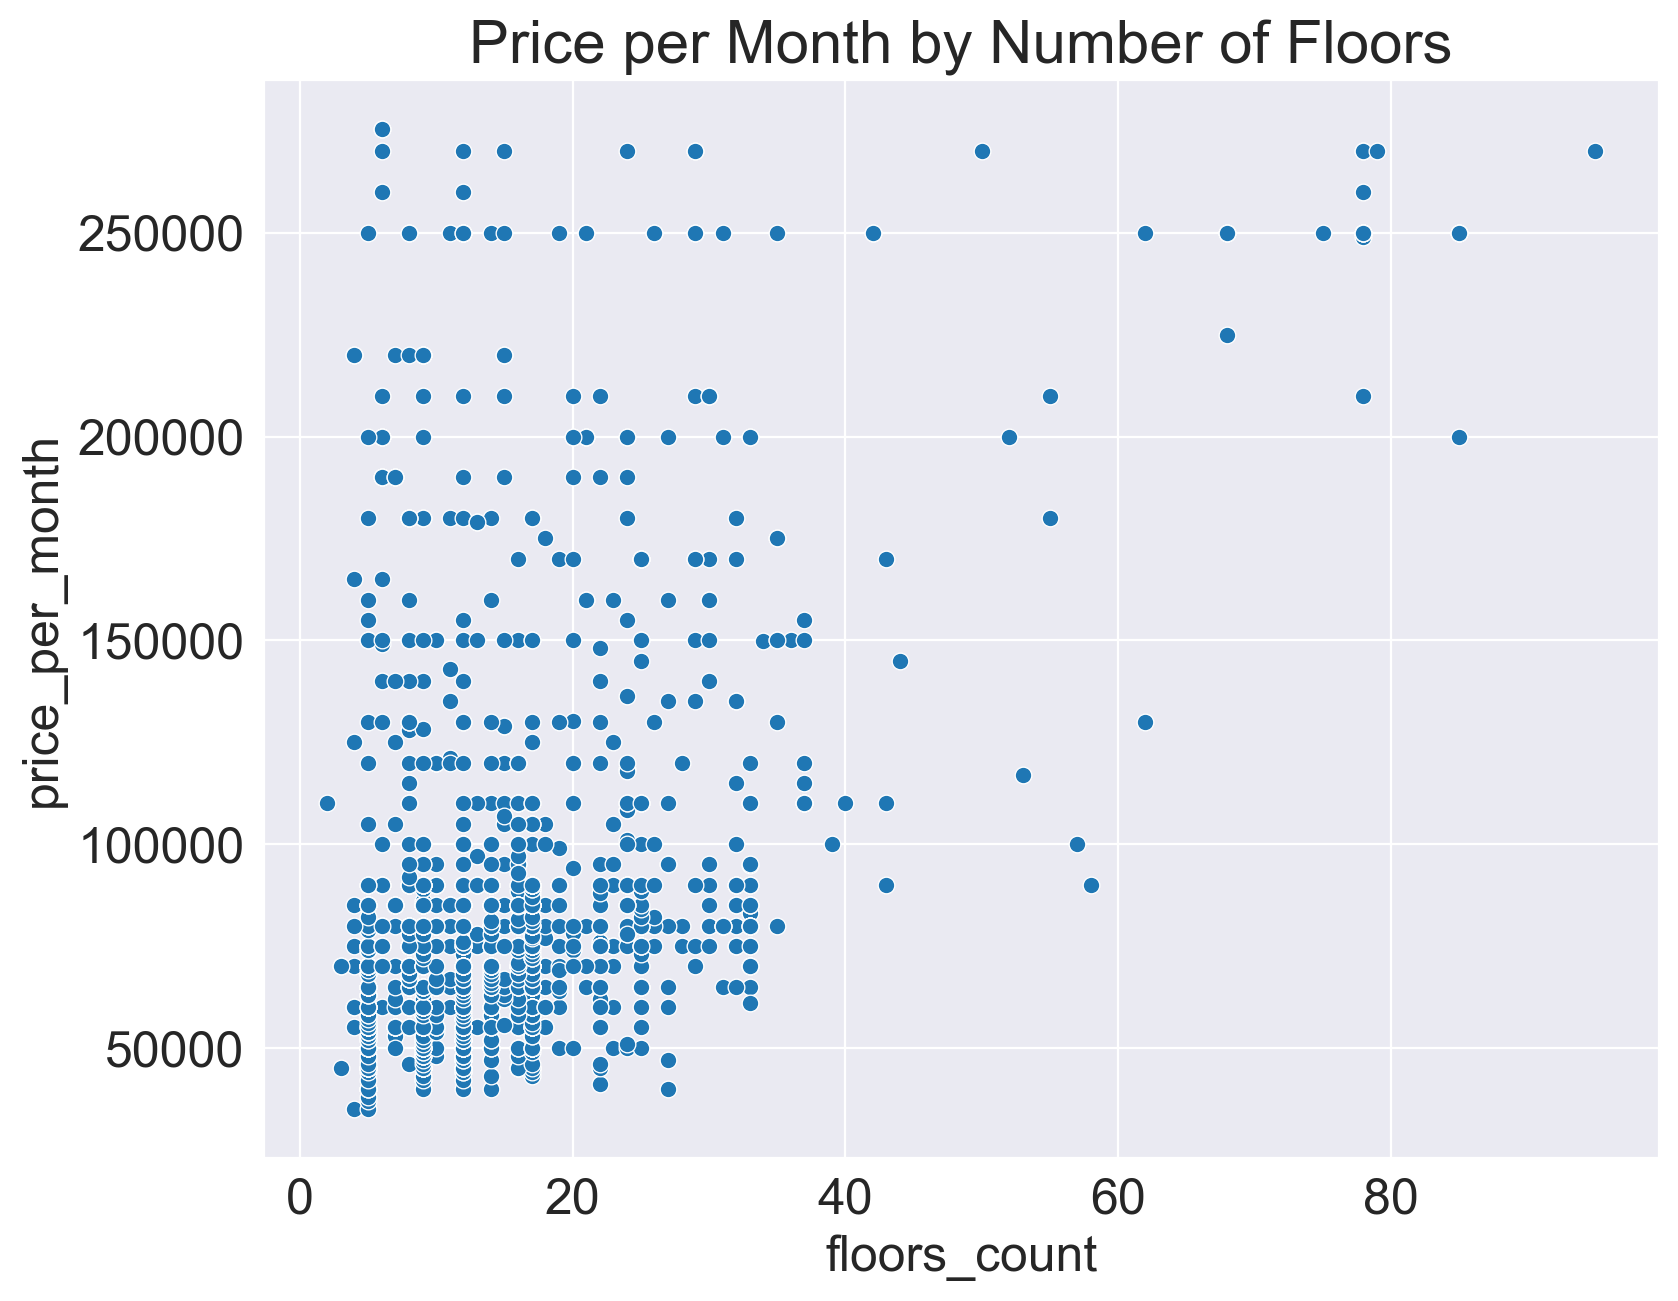

In [20]:
plt.figure(figsize=(9, 7))
sns.scatterplot(data=df[['price_per_month', 'floors_count']], x='floors_count', y='price_per_month')
plt.title("Price per Month by Number of Floors")

В целом да, какая-то слабая зависимость но всё же наблюдается. пока отложим это в сторонку

Есть идея создать два новых признака. Оба будут категориальные:
1) Насколько "в центре" нахоидится ближайшая станция метро. Она будет принимать следующие значения:
 - "В пределах кольцевой линии" - когда станция находится "внутри" пятой линии метро Москвы или сама является частью пятой линии
 - "В пределах МЦК" - когда станция за пределами пятой линии но внутри мцк (или часть мцк)
 - "В пределах БКЛ" - когда станция за пределами мцк но в пределах бкл (или часть бкл)
 - "В пределах МКАД" - когда станция за пределами бкл и мцк но в пределах мкад'а
 - "За пределами МКАД" - когда станция находится за пределами мкад'а

2) На какой линии находится станция. Значения будут численные (1, 5, 12 и т.д.) но обрабатываться как категориальные

In [21]:
print("Все станции метро из датасета:", df['underground'].unique())

Все станции метро из датасета: ['Новые Черёмушки' 'Новаторская' 'Окружная' 'Преображенская площадь'
 'Москва-Товарная' 'Чертановская' 'Нижегородская' 'Белорусская' 'Перово'
 'Сокол' 'Первомайская' 'Филёвский парк' 'Кожуховская' 'Кутузовская'
 'Кропоткинская' 'Братиславская' 'Москва-Сити' 'Улица Сергея Эйзенштейна'
 'Тургеневская' 'Кленовый бульвар' 'Севастопольская' 'Молодёжная'
 'Домодедовская' 'Ломоносовский проспект' 'Марьина Роща' 'Новокузнецкая'
 'Маяковская' 'Соколиная гора' 'Раменки' 'Беговая' 'ЦСКА'
 'Улица 1905 года' 'Курская' 'Бутырская' 'Арбатская' 'Красный Балтиец'
 'Яхромская' 'Крылатское' 'Каспийская' 'Смоленская' 'Авиамоторная'
 'Бульвар Рокоссовского' 'Стрешнево' 'Воронцовская' 'Шелепиха'
 'Беломорская' 'Аминьевская' 'Некрасовка' 'ЗИЛ' 'Бибирево' 'ВДНХ'
 'Спартак' 'Шаболовская' 'Солнцево' 'Трубная' 'Варшавская' 'Алексеевская'
 'Ясенево' 'Октябрьское поле' 'Красные ворота' 'Фили' 'Верхние Лихоборы'
 'Царицыно' 'Панфиловская' 'Водный стадион' 'Кунцевская' 'Киевская'
 'Уни

In [22]:
print("Их количество:", len(df['underground'].unique()))

Их количество: 240


Обе характеристики для данных станций определим с помощью ChatGPT а также ручной перепроверкой. Если станция находится на пересечении нескольких линий, то берём случайную.
Благо ChatGPT-4o хорошо "знаком" с метро Москвы

In [23]:
line_number_dict = {  # советую свернуть эту ячейку
    'Новые Черёмушки': 6,
    'Новаторская': 11,
    'Окружная': 10,
    'Преображенская площадь': 1,
    'Москва-Товарная': "D2",
    'Чертановская': 9,
    'Нижегородская': 14,
    'Белорусская': 5,
    'Перово': 8,
    'Сокол': 2,
    'Первомайская': 3,
    'Филёвский парк': 4,
    'Кожуховская': 10,
    'Кутузовская': 4,
    'Кропоткинская': 1,
    'Братиславская': 10,
    'Москва-Сити': "4A",
    'Улица Сергея Эйзенштейна': 13,
    'Тургеневская': 6,
    'Кленовый бульвар': 11,
    'Севастопольская': 9,
    'Молодёжная': 3,
    'Домодедовская': 2,
    'Ломоносовский проспект': 8,
    'Марьина Роща': 10,
    'Новокузнецкая': 2,
    'Маяковская': 2,
    'Соколиная гора': 14,
    'Раменки': 8,
    'Беговая': 7,
    'ЦСКА': 11,
    'Улица 1905 года': 7,
    'Курская': 5,
    'Бутырская': 10,
    'Арбатская': 4,
    'Красный Балтиец': "D2",
    'Яхромская': 10,
    'Крылатское': 3,
    'Каспийская': 2,
    'Смоленская': 4,
    'Авиамоторная': 8,
    'Бульвар Рокоссовского': 1,
    'Стрешнево': 14,
    'Воронцовская': 11,
    'Шелепиха': 11,
    'Беломорская': 2,
    'Аминьевская': 11,
    'Некрасовка': 15,
    'ЗИЛ': 11,
    'Бибирево': 9,
    'ВДНХ': 6,
    'Спартак': 7,
    'Шаболовская': 6,
    'Солнцево': 8,
    'Трубная': 10,
    'Варшавская': 11,
    'Алексеевская': 6,
    'Ясенево': 6,
    'Октябрьское поле': 7,
    'Красные ворота': 1,
    'Верхние Лихоборы': 10,
    'Царицыно': 2,
    'Панфиловская': 14,
    'Водный стадион': 2,
    'Кунцевская': 4,
    'Киевская': 5,
    'Университет': 1,
    'Плющево': "D3",
    'Войковская': 2,
    'Физтех': 10,
    'Бульвар Адмирала Ушакова': 12,
    'Пролетарская': 7,
    'Митино': 3,
    'Шипиловская': 10,
    'Деловой центр': 11,
    'Динамо': 2,
    'Локомотив': 14,
    'Спортивная': 1,
    'Аэропорт': 2,
    'Новослободская': 5,
    'Фрунзенская': 1,
    'Балтийская': 14,
    'Автозаводская': 2,
    'Охотный ряд': 1,
    'Проспект Вернадского': 1,
    'Профсоюзная': 6,
    'Окская': 15,
    'Перерва': "D2",
    'Давыдково': 11,
    'Сокольники': 1,
    'Новогиреево': 8,
    'Академическая': 6,
    'Калитники': "D2",
    'Черкизовская': 1,
    'Мичуринский проспект': 8,
    'Волоколамская': 3,
    'Хорошёвская': 11,
    'Петровский Парк': 11,
    'Пятницкое шоссе': 3,
    'Щукинская': 7,
    'Угрешская': 14,
    'Цветной бульвар': 9,
    'Улица Горчакова': 12,
    'Бабушкинская': 6,
    'Октябрьская': 6,
    'Бульвар Дмитрия Донского': 9,
    'Парк Культуры': 5,
    'Грачёвская': "D3",
    'Тушинская': 7,
    'Сходненская': 7,
    'Зюзино': 11,
    'Строгино': 3,
    'Тропарёво': 1,
    'Нагорная': 9,
    'Ботанический сад': 6,
    'Багратионовская': 4,
    'Филатов Луг': 1,
    'Новопеределкино': "8A",
    'Маяковская': 2,
    'Улица Милашенкова': 13,
    'Народное Ополчение': 11,
    'Лермонтовский проспект': 7,
    'Улица Скобелевская': 12,
    'Печатники': 10,
    'Матвеевская': "D4",
    'Саларьево': 1,
    'Дмитровская': 9,
    'Стахановская': 15,
    'Алма-Атинская': 2,
    'Гражданская': "D2",
    'Достоевская': 10,
    'Планерная': 7,
    'Алтуфьево': 9,
    'Нахимовский проспект': 9,
    'Коломенская': 2,
    'Фили': 4,
    'Свиблово': 6,
    'Академическая': 6,
    'Кузьминки': 7,
    'Жулебино': 7,
    'Коньково': 6,
    'Тульская': 9,
    'Электрозаводская': 3,
    'Красносельская': 1,
    'Деловой центр': 11,
    'Ростокино': 14,
    'Ленинский проспект': 6,
    'Марксистская': 8,
    'Площадь трёх вокзалов': "D4",
    'Улица 1905 года': 7,
    'Крымская': 14,
    'Улица Академика Янгеля': 9,
    'Отрадное': 9,
    'Чкаловская': 10,
    'Бауманская': 3,
    'Люблино': 10,
    'Полежаевская': 11,
    'Рассказовка': 8,
    'Пионерская': 4,
    'Щёлковская': 3,
    'Рабочий посёлок': "D1",
    'Волгоградский проспект': 7,
    'Озёрная': 8,
    'Нагатинский Затон': 11,
    'Тимирязевская': 9,
    'Павелецкая': 5,
    'Стрешнево': 14,
    'Ломоносовский проспект': 8,
    'Беляево': 6,
    'Зябликово': 10,
    'Каховская': 11,
    'Медведково': 6,
    'Крестьянская застава': 10,
    'Университет Дружбы Народов': 6,
    'Моссельмаш': "D3",
    'Дубровка': 10,
    'Студенческая': 4,
    'Автозаводская': 2,
    'Юго-Западная': 1,
    'Крылатское': 3,
    'Профсоюзная': 6,
    'Яхромская': 10,
    'Зеленоград — Крюково': "D3",
    'Красный Строитель': "D2",
    'Коптево': 14,
    'Бунинская аллея': 12,
    'Ховрино': 2,
    'Измайловская': 3,
    'Речной вокзал': 2,
    'Выхино': 7,
    'Пыхтино': 8,
    'Сетунь': "D1",
    'Лианозово': 10,
    'Бескудниково': 8,
    'Юго-Восточная': 15,
    'Дегунино': 8,
    'Воронцовская': 11,
    'Вешняки': "D3",
    'Улица Дмитриевского': 15,
    'Борисово': 10,
    'Волжская': 10,
    'Балтийская': 14,
    'Кантемировская': 2,
    'Лихоборы': 14,
    'Южная': 9,
    'Лухмановская': 15,
    'Измайлово': 14,
    'Петровско-Разумовская': 9,
    'Бутово': "D2",
    'Курьяново': "D2",
    'Владыкино': 9,
    'Красногвардейская': 2,
    'Говорово': 8,
    'Потапово': 12,
    'Хорошёвская': 11,
    'Фонвизинская': 10,
    'Шаболовская': 6,
    'Савёловская': 2,
    'Проспект Мира': 5,
    'Шоссе Энтузиастов': 8,
    'Солнечная': "D4",
    'Краснопресненская': 5,
    'Новоясеневская': 6,
    'Хорошёво': 14,
    'Коммунарка': 1,
    'Лесопарковая': 12,
    'Депо': "D2",
    'Лефортово': 11,
    'Селигерская': 10,
    'Площадь Ильича': 8,
    'Семёновская': 3,
    'Орехово': 2,
    'Аннино': 9,
    'Текстильщики': 7,
    'Новокосино': 8,
    'Технопарк': 2,
    'Спортивная': 1,
    'Фрунзенская': 1,
    'Славянский бульвар': 3,
    'Серпуховская': 9,
    'Комсомольская': 5,
    'Сортировочная': "D3",
    'Цветной бульвар': 9,
    'Москворечье': "D2",
    'Марьино': 10,
    'Сухаревская': 6,
    'Рижская': 11,
    'Менделеевская': 9,
    'Таганская': 7,
    'Новокузнецкая': 2,
    'Добрынинская': 5,
    'Парк Победы': 3,
    'Боровское шоссе': 8,
    'Октябрьская': 5,
    'Бутырская': 10,
    'Пушкинская': 7,
    'Минская': "8A",
    "Китай-город": 6,
    'Чистые пруды': 1,
    'Баррикадная': 7,   
}

In [24]:
ZONE1 = 'В пределах кольцевой линии'
ZONE2 = 'В пределах МЦК'
ZONE3 = 'В пределах БКЛ'
ZONE4 = 'В пределах МКАД'
ZONE5 = 'За пределами МКАД'

In [25]:
metro_zone = {  # советую свернуть эту ячейку
'Новые Черёмушки': ZONE3,
'Новаторская': ZONE3,
'Окружная': ZONE2,
'Преображенская площадь': ZONE3,
'Москва-Товарная': ZONE3,
'Чертановская': ZONE3,
'Нижегородская': ZONE3,
'Белорусская': ZONE1,
'Перово': ZONE3,
'Сокол': ZONE3,
'Первомайская': ZONE4,
'Филёвский парк': ZONE3,
'Кожуховская': ZONE3,
'Кутузовская': ZONE3,
'Кропоткинская': ZONE1,
'Братиславская': ZONE4,
'Москва-Сити': ZONE2,
'Улица Сергея Эйзенштейна': ZONE3,
'Тургеневская': ZONE1,
'Кленовый бульвар': ZONE3,
'Севастопольская': ZONE3,
'Молодёжная': ZONE3,
'Домодедовская': ZONE4,
'Ломоносовский проспект': ZONE4,
'Марьина Роща': ZONE3,
'Новокузнецкая': ZONE1,
'Маяковская': ZONE1,
'Соколиная гора': ZONE3,
'Раменки': ZONE4,
'Беговая': ZONE2,
'ЦСКА': ZONE2,
'Улица 1905 года': ZONE1,
'Курская': ZONE1,
'Бутырская': ZONE3,
'Арбатская': ZONE1,
'Красный Балтиец': ZONE3,
'Яхромская': ZONE4,
'Крылатское': ZONE3,
'Каспийская': ZONE4,
'Смоленская': ZONE1,
'Авиамоторная': ZONE3,
'Бульвар Рокоссовского': ZONE3,
'Стрешнево': ZONE2,
'Воронцовская': ZONE3,
'Шелепиха': ZONE2,
'Беломорская': ZONE4,
'Аминьевская': ZONE3,
'Некрасовка': ZONE5,
'ЗИЛ': ZONE2,
'Бибирево': ZONE4,
'ВДНХ': ZONE3,
'Спартак': ZONE2,
'Шаболовская': ZONE1,
'Солнцево': ZONE4,
'Трубная': ZONE1,
'Варшавская': ZONE3,
'Алексеевская': ZONE3,
'Ясенево': ZONE4,
'Октябрьское поле': ZONE3,
'Красные ворота': ZONE1,
'Фили': ZONE3,
'Верхние Лихоборы': ZONE4,
'Царицыно': ZONE4,
'Панфиловская': ZONE2,
'Водный стадион': ZONE3,
'Кунцевская': ZONE4,
'Киевская': ZONE1,
'Университет': ZONE1,
'Плющево': ZONE3,
'Войковская': ZONE3,
'Физтех': ZONE5,
'Бульвар Адмирала Ушакова': ZONE4,
'Пролетарская': ZONE2,
'Митино': ZONE5,
'Шипиловская': ZONE4,
'Деловой центр': ZONE2,
'Динамо': ZONE1,
'Локомотив': ZONE3,
'Спортивная': ZONE1,
'Аэропорт': ZONE1,
'Новослободская': ZONE1,
'Фрунзенская': ZONE1,
'Балтийская': ZONE2,
'Автозаводская': ZONE1,
'Охотный ряд': ZONE1,
'Проспект Вернадского': ZONE1,
'Профсоюзная': ZONE3,
'Окская': ZONE5,
'Перерва': ZONE3,
'Давыдково': ZONE4,
'Сокольники': ZONE1,
'Новогиреево': ZONE4,
'Академическая': ZONE3,
'Калитники': ZONE3,
'Черкизовская': ZONE3,
'Мичуринский проспект': ZONE4,
'Волоколамская': ZONE5,
'Хорошёвская': ZONE2,
'Петровский Парк': ZONE2,
'Пятницкое шоссе': ZONE5,
'Щукинская': ZONE3,
'Угрешская': ZONE2,
'Цветной бульвар': ZONE1,
'Улица Горчакова': ZONE4,
'Бабушкинская': ZONE4,
'Октябрьская': ZONE1,
'Бульвар Дмитрия Донского': ZONE4,
'Парк Культуры': ZONE1,
'Грачёвская': ZONE3,
'Тушинская': ZONE4,
'Сходненская': ZONE4,
'Зюзино': ZONE3,
'Строгино': ZONE5,
'Гражданская': ZONE3,
'Тропарёво': ZONE4,
'Площадь Ильича': ZONE1,
'Нагорная': ZONE3,
'Ботанический сад': ZONE3,
'Пушкинская': ZONE1,
'Багратионовская': ZONE3,
'Филатов Луг': ZONE4,
'Новопеределкино': ZONE5,
'Улица Милашенкова': ZONE3,
'Народное Ополчение': ZONE3,
'Лермонтовский проспект': ZONE4,
'Улица Скобелевская': ZONE4,
'Печатники': ZONE3,
'Матвеевская': ZONE3,
'Каховская': ZONE3,
'Саларьево': ZONE4,
'Серпуховская': ZONE1,
'Дмитровская': ZONE3,
'Парк Победы': ZONE3,
'Стахановская': ZONE5,
'Алма-Атинская': ZONE4,
'Достоевская': ZONE1,
'Дубровка': ZONE2,
'Планерная': ZONE4,
'Алтуфьево': ZONE4,
'Нахимовский проспект': ZONE3,
'Коломенская': ZONE3,
'Свиблово': ZONE3,
'Рассказовка': ZONE5,
'Кузьминки': ZONE3,
'Жулебино': ZONE4,
'Коньково': ZONE4,
'Тульская': ZONE3,
'Электрозаводская': ZONE1,
'Красносельская': ZONE1,
'Юго-Западная': ZONE4,
'Ростокино': ZONE2,
'Ленинский проспект': ZONE3,
'Марксистская': ZONE1,
'Площадь трёх вокзалов': ZONE1,
'Комсомольская': ZONE1,
'Крымская': ZONE2,
'Улица Академика Янгеля': ZONE4,
'Отрадное': ZONE4,
'Чкаловская': ZONE1,
'Бауманская': ZONE1,
'Люблино': ZONE4,
'Полежаевская': ZONE1,
'Пионерская': ZONE3,
'Щёлковская': ZONE4,
'Рабочий посёлок': ZONE3,
'Волгоградский проспект': ZONE1,
'Минская': ZONE4,
'Озёрная': ZONE4,
'Китай-город': ZONE1,
'Нагатинский Затон': ZONE4,
'Тимирязевская': ZONE2,
'Чистые пруды': ZONE1,
'Павелецкая': ZONE1,
'Сухаревская': ZONE1,
'Беляево': ZONE4,
'Зябликово': ZONE4,
'Баррикадная': ZONE1,
'Добрынинская': ZONE1,
'Медведково': ZONE4,
'Крестьянская застава': ZONE3,
'Университет Дружбы Народов': ZONE5,
'Моссельмаш': ZONE3,
'Таганская': ZONE1,
'Студенческая': ZONE3,
'Зеленоград — Крюково': ZONE5,
'Красный Строитель': ZONE3,
'Коптево': ZONE2,
'Бунинская аллея': ZONE4,
'Ховрино': ZONE3,
'Измайловская': ZONE4,
'Речной вокзал': ZONE4,
'Выхино': ZONE4,
'Пыхтино': ZONE5,
'Сетунь': ZONE2,
'Лианозово': ZONE4,
'Бескудниково': ZONE4,
'Юго-Восточная': ZONE5,
'Дегунино': ZONE4,
'Вешняки': ZONE4,
'Улица Дмитриевского': ZONE5,
'Борисово': ZONE4,
'Волжская': ZONE4,
'Кантемировская': ZONE4,
'Лихоборы': ZONE2,
'Южная': ZONE4,
'Лухмановская': ZONE5,
'Измайлово': ZONE3,
'Петровско-Разумовская': ZONE3,
'Бутово': ZONE5,
'Курьяново': ZONE3,
'Владыкино': ZONE2,
'Красногвардейская': ZONE4,
'Говорово': ZONE4,
'Потапово': ZONE5,
'Фонвизинская': ZONE3,
'Савёловская': ZONE3,
'Проспект Мира': ZONE1,
'Шоссе Энтузиастов': ZONE3,
'Солнечная': ZONE4,
'Краснопресненская': ZONE1,
'Новоясеневская': ZONE4,
'Хорошёво': ZONE2,
'Коммунарка': ZONE5,
'Лесопарковая': ZONE5,
'Депо': ZONE3,
'Лефортово': ZONE3,
'Селигерская': ZONE3,
'Семёновская': ZONE3,
'Орехово': ZONE4,
'Аннино': ZONE4,
'Текстильщики': ZONE3,
'Новокосино': ZONE5,
'Технопарк': ZONE3,
'Славянский бульвар': ZONE3,
'Сортировочная': ZONE3,
'Москворечье': ZONE3,
'Марьино': ZONE4,
'Рижская': ZONE2,
'Менделеевская': ZONE1,
'Боровское шоссе': ZONE4
}

In [26]:
df['line_number'] = df['underground'].apply(lambda x: str(line_number_dict[x])).astype("object")

In [27]:
df['metro_zone'] = df['underground'].apply(lambda x: metro_zone[x]).astype("object")

In [28]:
df.sample(2)

,author,author_type,url,floor,floors_count,rooms_count,total_meters,price_per_month,district,street,house_number,underground,line_number,metro_zone
91,Whitewill Аренда,real_estate_agent,https://www.cian.ru/rent/flat/300227546/,3,21,2,57.0,250000,Пресненский,2-я Звенигородская,16,Улица 1905 года,7,В пределах кольцевой линии
1232,MY HOME,real_estate_agent,https://www.cian.ru/rent/flat/301748875/,9,22,2,43.0,75000,Западное Дегунино,Дегунинская,9к1,Моссельмаш,D3,В пределах БКЛ


Text(0.5, 1.0, 'Price per Month by Metro Zone')

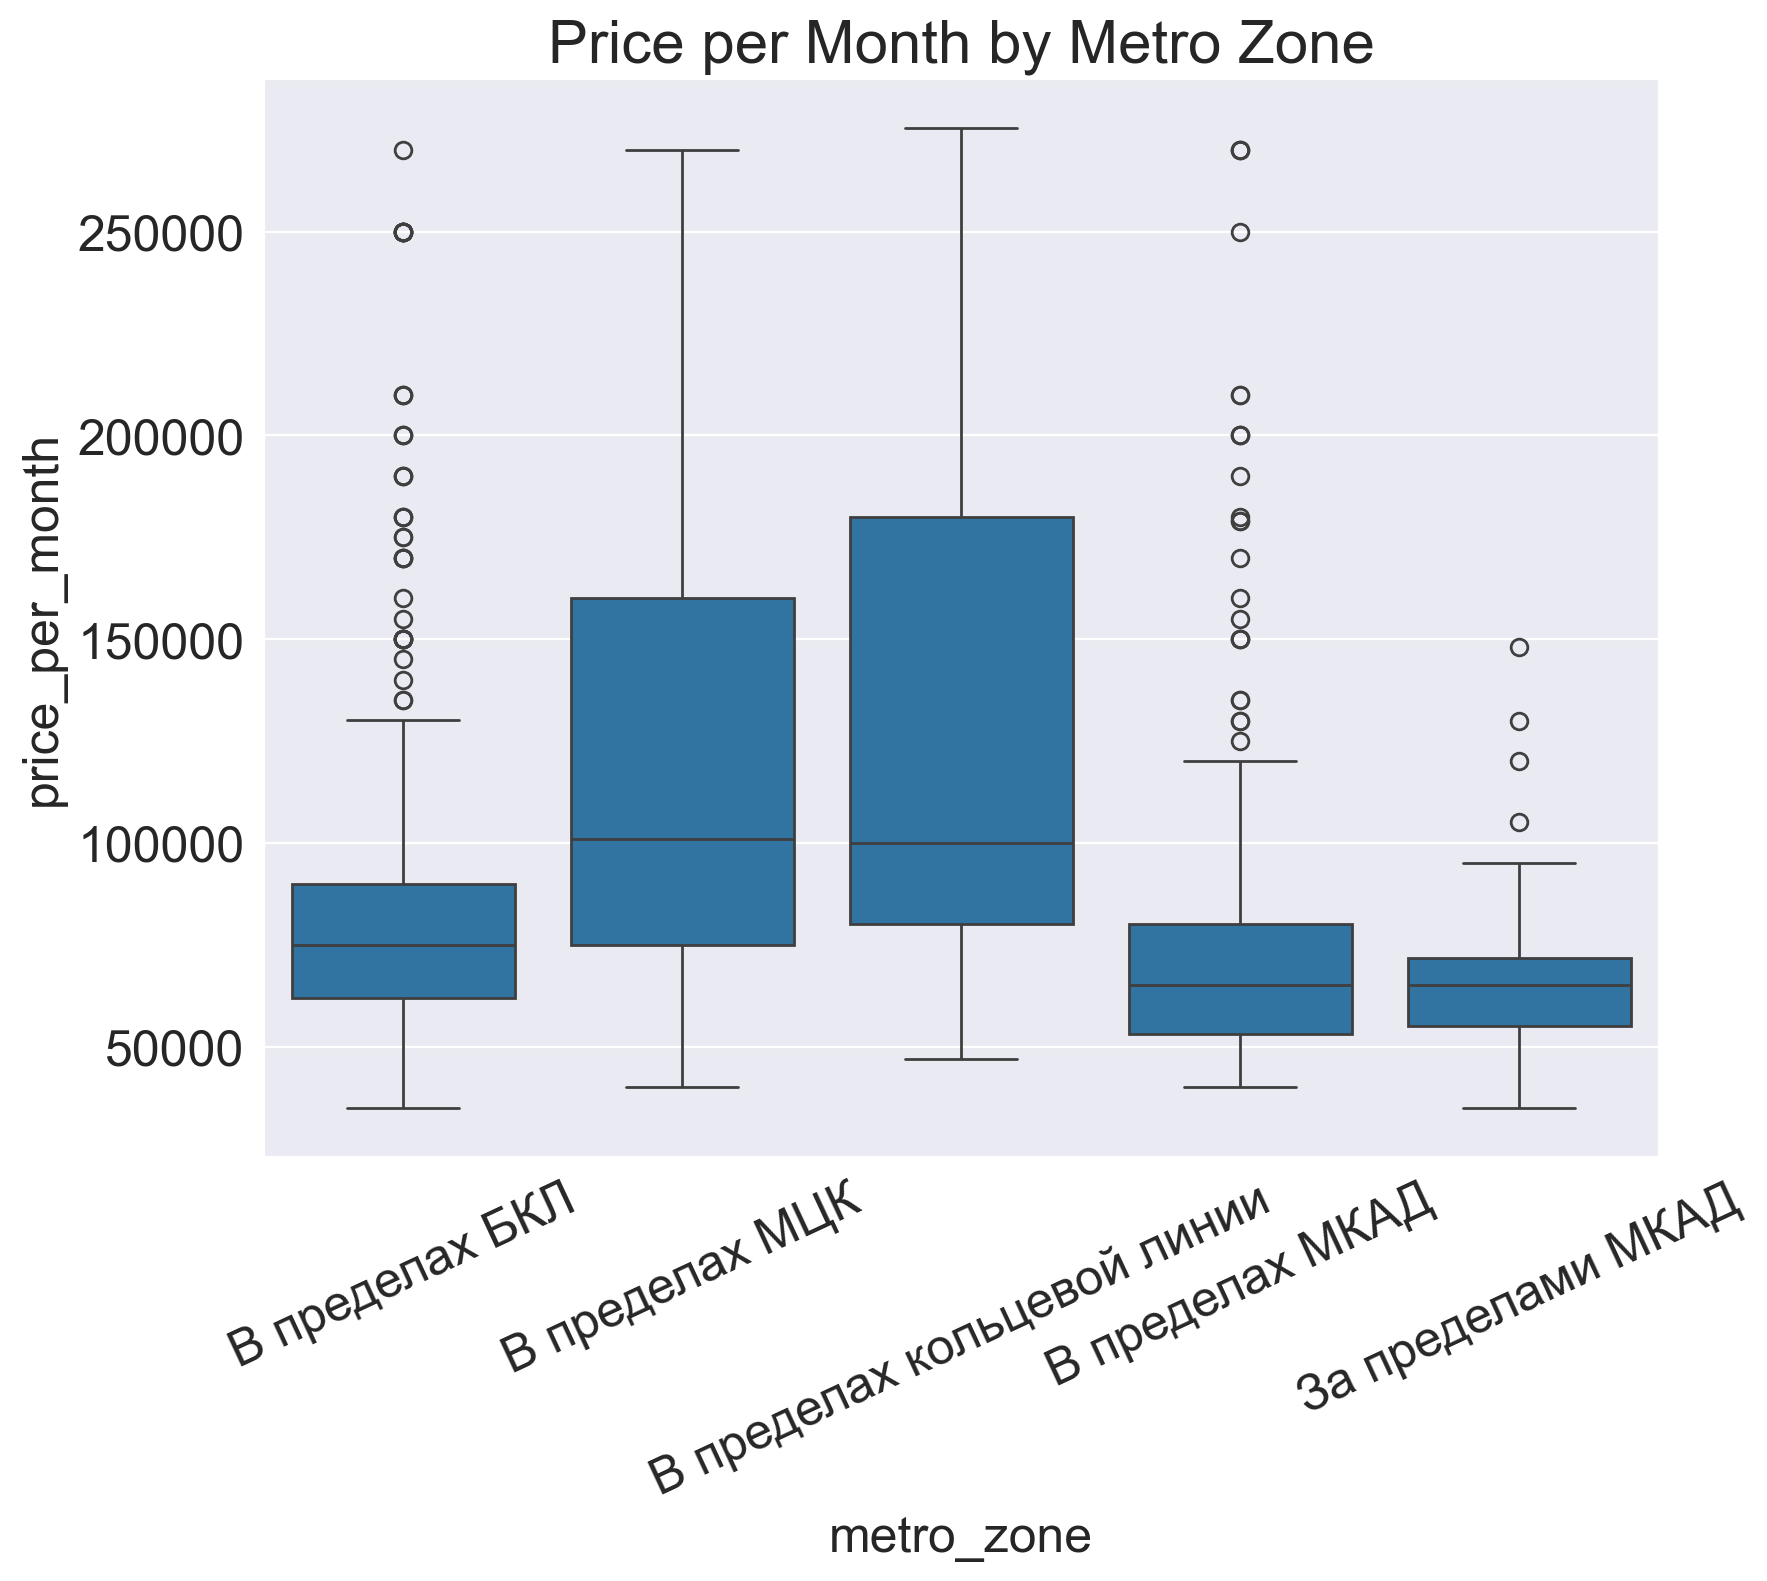

In [29]:
plt.figure(figsize=(9, 7))
sns.boxplot(data=df[['price_per_month', 'metro_zone']], x='metro_zone', y='price_per_month')
plt.xticks(rotation=25)
plt.title("Price per Month by Metro Zone")

In [30]:
df.groupby('metro_zone')['price_per_month'].agg(['mean', 'median'])

,mean,median
metro_zone,,
В пределах БКЛ,83743.816068,75000.0
В пределах МКАД,73225.605634,65000.0
В пределах МЦК,124195.311111,100990.0
В пределах кольцевой линии,128628.137778,100000.0
За пределами МКАД,66385.544444,65000.0


Можно заметить что показатели квартир которые находится за МКАД'ом не сильно отличаются от тех, что в его пределах но за пределами 14ой и 11ой линий метро. Давайте это и возьмём как гипотезу и попробуем проверить действительно ли это так

### Шаг 6. проверка гипотезы

**Гипотеза**: *Цены квартир в зоне "За пределами МКАД" не отличаются значительно от цен в зоне "Между МКАД и МЦК-БКЛ"*

Сперва посмотрим на распределение данных и проверим их тестом Шапиро-Уилка на нормальное распределение

Text(0.5, 1.0, 'Price distribution in zone 4')

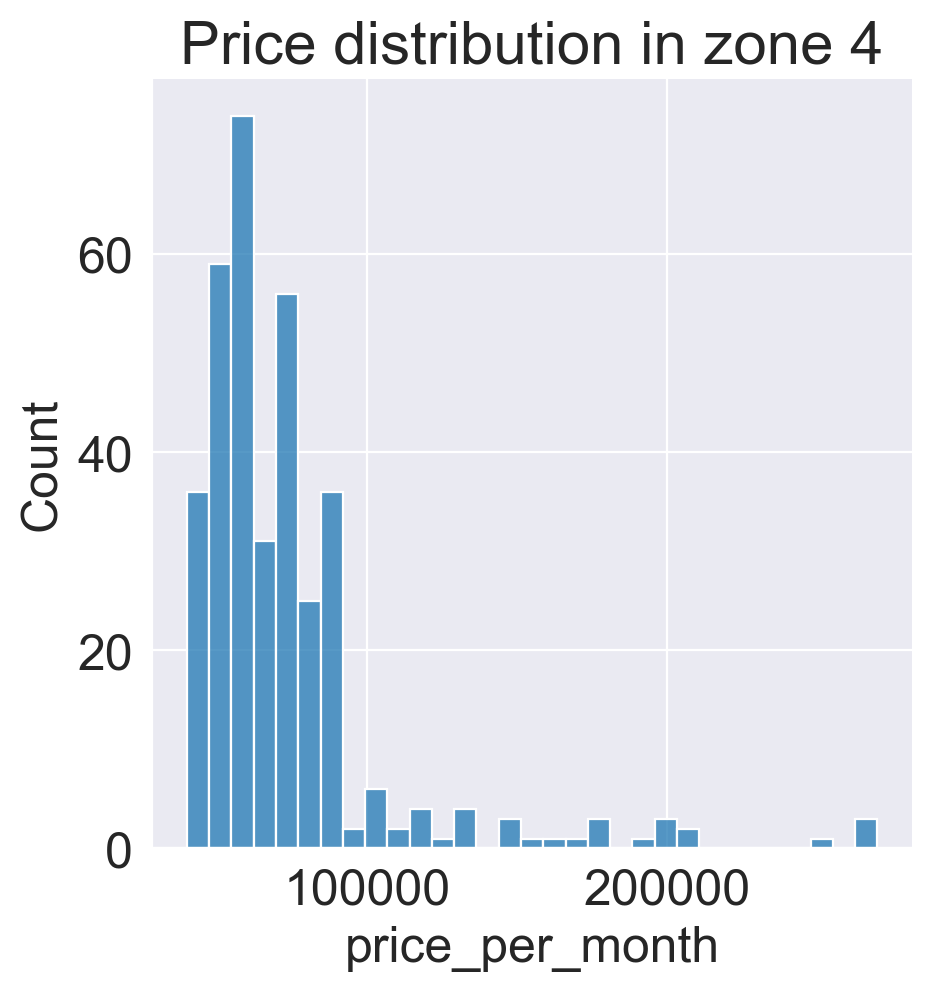

In [31]:
sns.displot(df[df['metro_zone'] == ZONE4]['price_per_month'])
plt.title("Price distribution in zone 4")

Text(0.5, 1.0, 'Price distribution in zone 5')

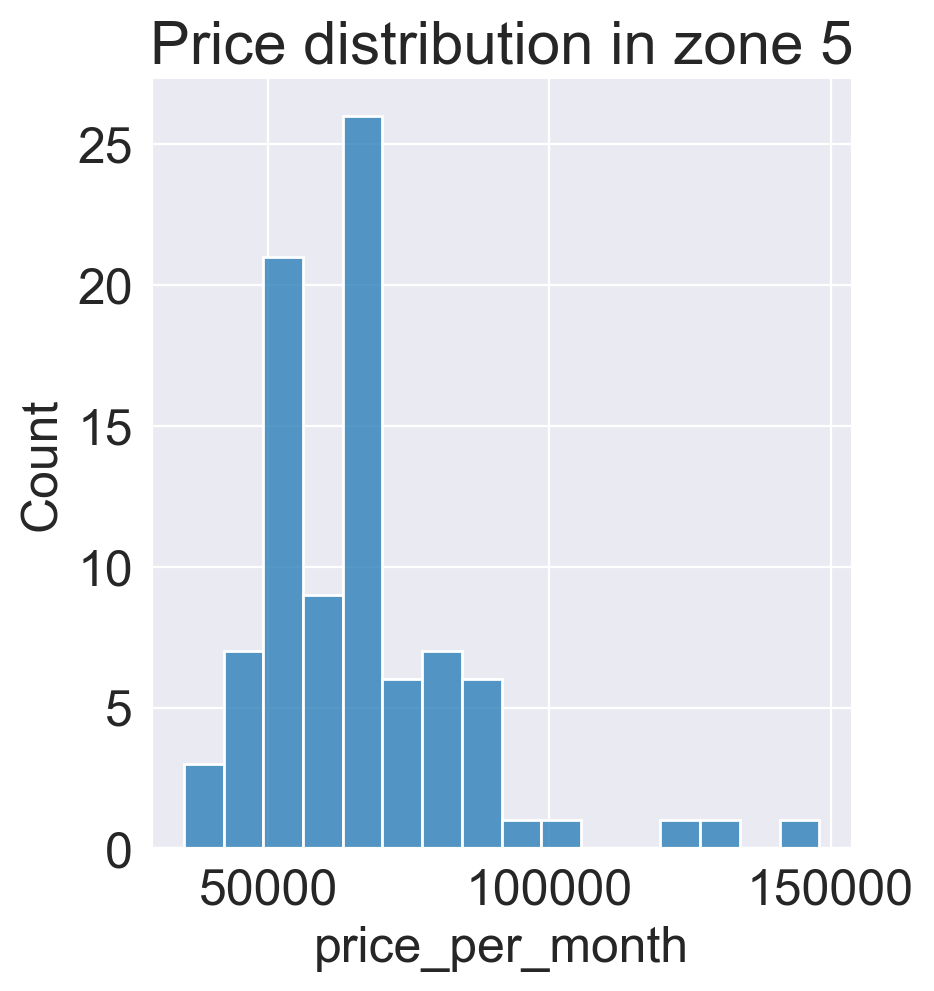

In [32]:
sns.displot(df[df['metro_zone'] == ZONE5]['price_per_month'])
plt.title("Price distribution in zone 5")

In [33]:
shapiro_zone_4 = stats.shapiro(df[df['metro_zone'] == ZONE4]['price_per_month'])
shapiro_zone_5 = stats.shapiro(df[df['metro_zone'] == ZONE5]['price_per_month'])
print(f"Shapiro-Wilk Тест для группы 'В пределах МКАД': {shapiro_zone_4}")
print(f"Shapiro-Wilk Тест для группы 'За пределами МКАД': {shapiro_zone_5}")

Shapiro-Wilk Тест для группы 'В пределах МКАД': ShapiroResult(statistic=0.6673508882522583, pvalue=8.462305064044188e-26)
Shapiro-Wilk Тест для группы 'За пределами МКАД': ShapiroResult(statistic=0.878617525100708, pvalue=5.040727728555794e-07)


В обоих случаях P-value > 0.05, следовательно нет достаточных оснований отвергнуть нулевую гипотезу, то есть данные не показывают значительных отклонений от нормального распределения

**Так как мы хотим сравнить разность между значениями двух групп и распределение данных в обеих группах НЕ являются НЕ нормальным, мы будем использовать T-test в качестве математического подтверждения**

In [34]:
t_stat, p_value = stats.ttest_ind(shapiro_zone_4, shapiro_zone_5, equal_var=False)
print(f"T test: statistic: {t_stat}, p-Value: {p_value}")

T test: statistic: -0.19148231552948716, p-Value: 0.8669420537885697


P-value > 0.05 следовательно нет достаточных оснований отвергнуть нулевую гипотезу, **то есть нет значимых различий между средними значениями двух групп**

***Основываясь на результатах данной мат. модели мы можем утверждать что для площадки ЦИАН нет значительной разницы где выбирать квартиру : за пределами МКАД или "между МКАД и МЦК-БКЛ"***

### Шаг 7. Машинное обучение

Попробуем предсказать цену квартиры с помощью линейной регрессии.
Так как данных не сказать что много и каких-то сильных признаков у меня в датасете нет, я поставлю цель не столько предсказать месячную стоимость дома рубль в рубль, сколько предсказать её порядок с какой-то погрешностью. Если модель говорит что будет 200тыс. руб. / мес, это должно значить как минимум то что квартира будет в диапазоне от 150тыс. руб. до 250тыс. руб.

Разобьём данные на обучающую и тестовую выборки:

In [35]:
from sklearn.model_selection import train_test_split

y = df["price_per_month"]
X = df.drop(columns=["price_per_month"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Бейзлайном выступит предсказание среднего значения

In [36]:
from sklearn.metrics import root_mean_squared_error

best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % root_mean_squared_error(y_test, best_constant * np.ones(y_test.shape)))
print("Train RMSE with best constant = %.4f" % root_mean_squared_error(y_train, best_constant * np.ones(y_train.shape)))

Test RMSE with best constant = 51584.5211
Train RMSE with best constant = 50582.5355


Можно подумать, что: *"А зачем тогда нам какую-то модель строить если предсказанием среднего мы по факту уже добились желаемого результата?"*

Но ведь если квартира стоит миллион рублей в месяц (условно), или тысяч 300 даже, среднее предсказание всё еще будет 80-90 тысяч как мы помним из исследования выше. В то время как модель предскажет более точно число. Это нам и нужно

Определим столбцы которые будут участвовать в линейной регрессии:

In [37]:
categorical = ['author_type', 'line_number', 'metro_zone', 'street', 'underground', 'district']
numeric = ['floor', 'floors_count', 'rooms_count', 'total_meters']

Для обработки данных будет использовать OHE и StandartScaler для категориальных и численных столбцов соответсвенно

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_pred))

y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Train RMSE = 14883.8970
Test RMSE = 27240.5048


Наблюдаем очень сильное переобучение. Посмотрим на размер итоговой обучающей выборки после OHE:

In [39]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

column_transformer.fit_transform(X_train)

<894x829 sparse matrix of type '<class 'numpy.float64'>'
	with 8940 stored elements in Compressed Sparse Row format>

Так как мы использовали такие столбцы как street, underground и disctirct, которые имеют большое количество уникальных значений, после преобразования количество наблюдений в выборке практически совпало с количеством признаков. Это просто *ужас* поэтому уберём эти столбцы. Они не несут критично много информации, так что это не большая потеря в данных

In [40]:
categorical = ['author_type', 'line_number', 'metro_zone']

In [41]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_pred))

y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Train RMSE = 28782.4734
Test RMSE = 30838.7431


Ну вот. Теперь переобучения куда меньше. Давайте также подберём гиперпараметр для этой модели

Best alpha = 2.3357


Text(0.5, 1.0, 'Cross-Validation Scores for Different Alpha Values')

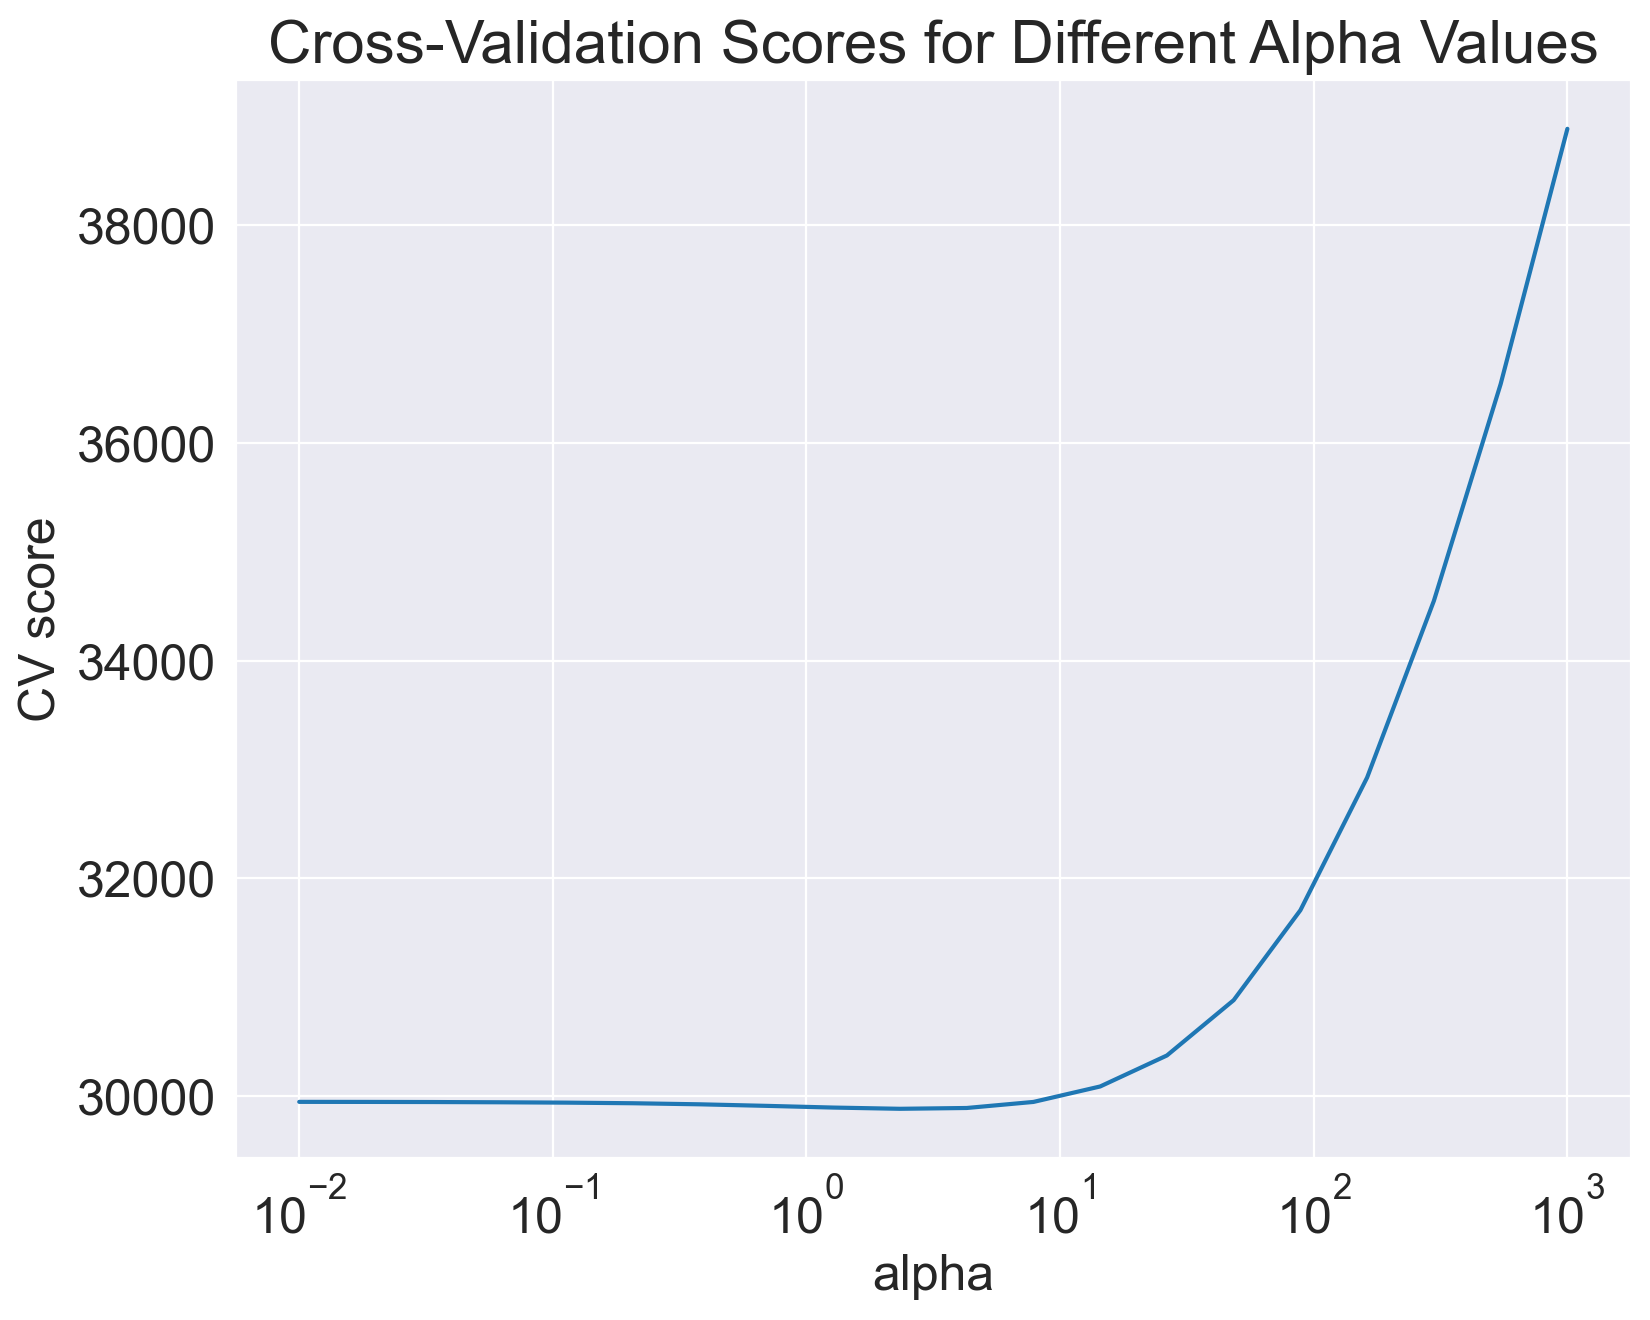

In [42]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.figure(figsize=(9, 7))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title("Cross-Validation Scores for Different Alpha Values")

In [43]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

model = pipeline.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_pred))

y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Train RMSE = 28806.9861
Test RMSE = 30874.7901


Это сильно ни на что не повлияло. Давайте теперь попробуем использовать регрессию с *l1* регуляризацией

In [44]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_pred))

y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Train RMSE = 28775.1028
Test RMSE = 30813.8202


c:\Users\Vex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81298945409.08936, tolerance: 228738205.33496067
  model = cd_fast.sparse_enet_coordinate_descent(


In [45]:
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 2


Также подберём для неё гиперпараметр:

Best alpha = 127.4275


Text(0.5, 1.0, 'Cross-Validation Scores for Different Alpha Values')

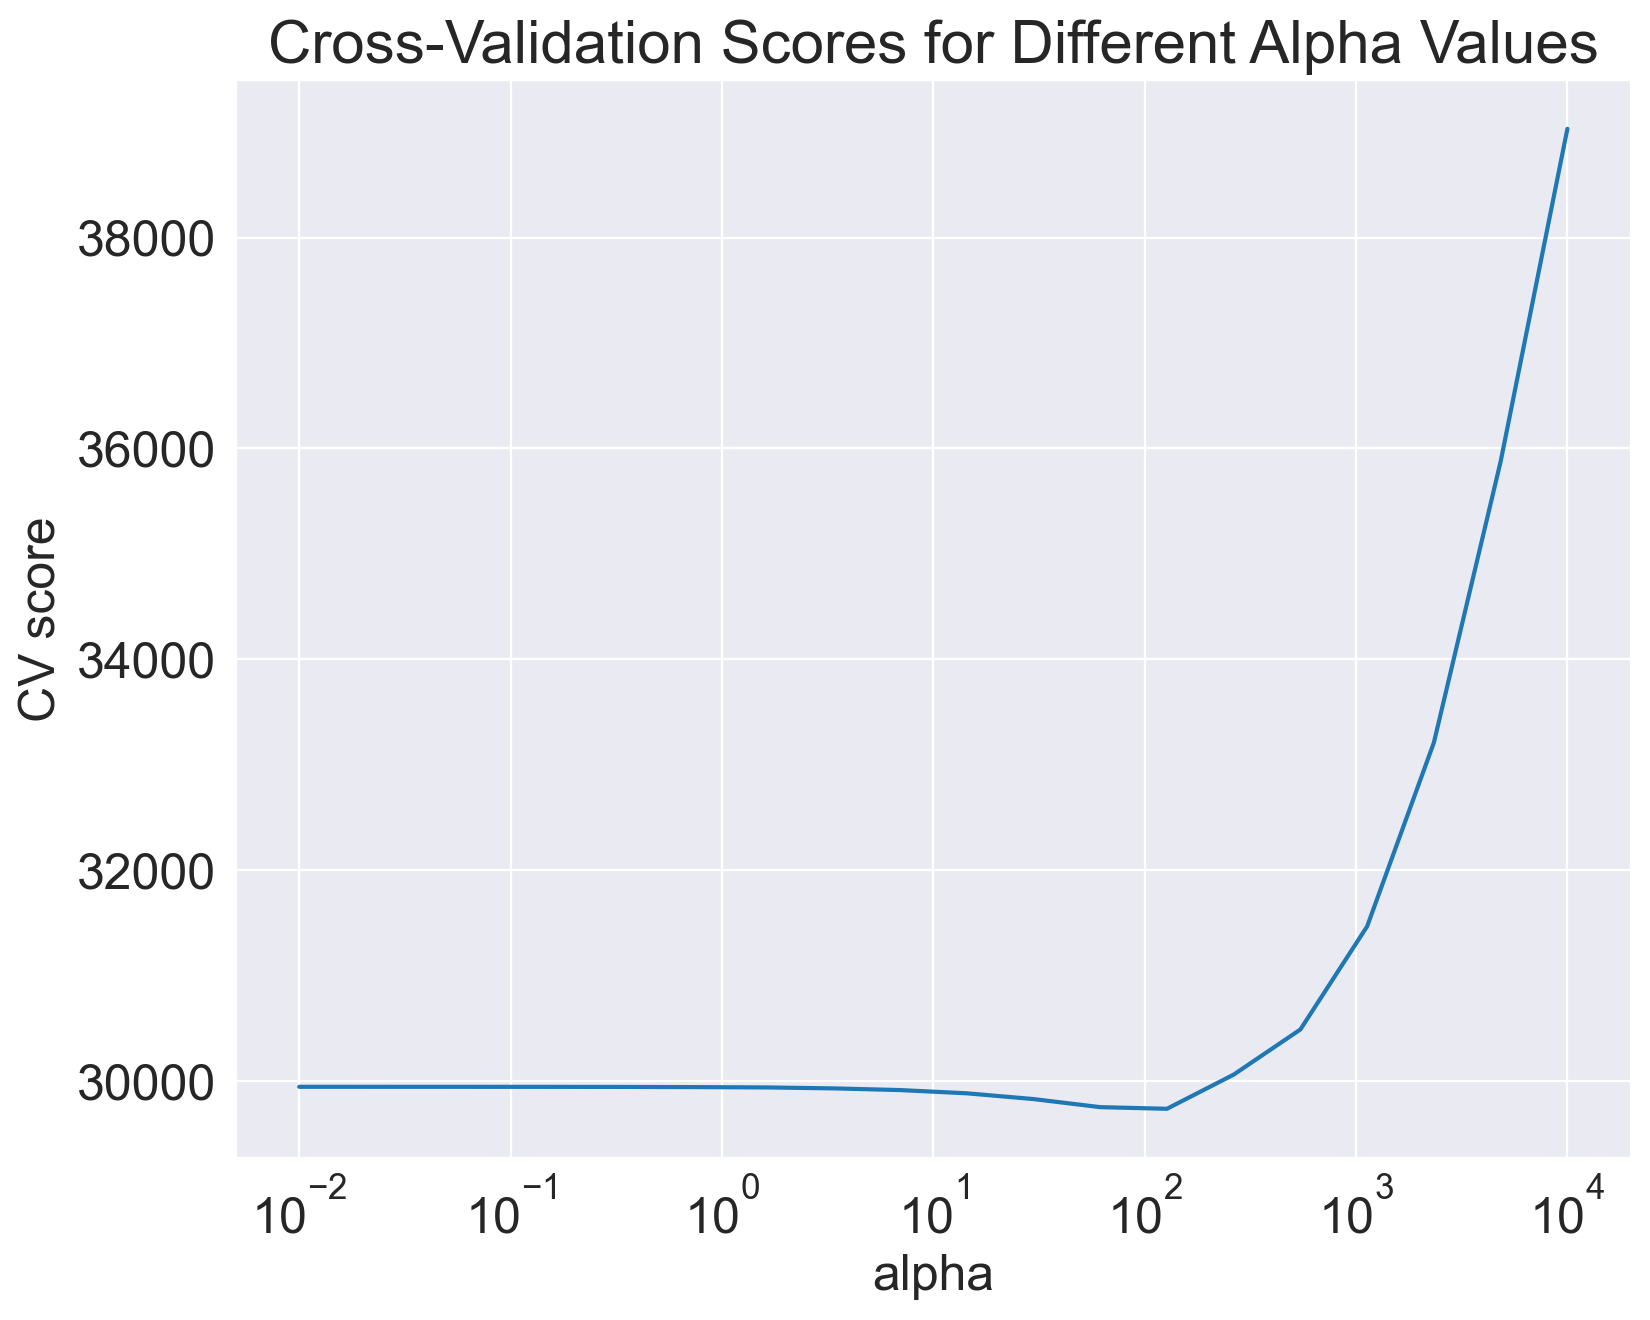

In [46]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.figure(figsize=(9, 7))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.title("Cross-Validation Scores for Different Alpha Values")

In [47]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = lasso_pipeline.fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_pred))

y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Train RMSE = 28945.3297
Test RMSE = 31075.8658


Стало даже немного хуже =D

Поставленной задачи мы достигнули, и как никак побили бейзлайн, что уже хорошо

### Вывод

1. Описание результатов
В ходе исследования цен на квартиры, взятых с платформы ЦИАН, я провела анализ данных и выполнила несколько статистических тестов и моделей. Основные результаты включают:

- Анализ различий в ценах по зонам:
Проведенный T-тест показал, что цены на квартиры в зоне "за МКАД" и в зоне "между МКАД и МЦК-БКЛ" не различаются статистически значимо. Это означает, что средняя стоимость квартиры в этих зонах практически одинакова.
- Модель линейной регрессии:
Я построила модель линейной регрессии для предсказания ежемесячной стоимости аренды квартиры. Модель была оценена с использованием метрики RMSE (корень из среднеквадратичной ошибки), и результат составил 30 тысяч рублей. Это означает, что в среднем, предсказанная моделью стоимость аренды отличается от фактической на 30 тысяч рублей.

2. Применение результатов
Результаты этого исследования и построенные модели могут быть полезны в нескольких аспектах:

- Для арендаторов и покупателей:
Понимание, что цены на квартиры за пределами МКАД и между МКАД и МЦК-БКЛ не различаются, может помочь арендаторам и покупателям принимать более информированные решения. Они могут выбирать квартиры в этих зонах, основываясь на других факторах, таких как удобство транспортной доступности или наличие инфраструктуры, не опасаясь значительных ценовых различий.
- Для риелторов и агентств недвижимости:
Полученные данные и модель линейной регрессии могут использоваться для более точного прогнозирования стоимости аренды квартир. Это может улучшить качество оценки недвижимости и помочь в более эффективном управлении портфелем недвижимости.
- Для исследований и анализа рынка недвижимости:
Выводы о том, что цены в определенных зонах не различаются, могут использоваться в дальнейшем исследовании рынка недвижимости. Аналитики могут более детально исследовать другие факторы, влияющие на стоимость квартир, зная, что географическое положение (в пределах анализируемых зон) не является ключевым фактором.


В целом, проведенное исследование и разработанная модель предоставляют ценные инсайты и инструменты для различных участников рынка недвижимости, улучшая понимание ценообразования и способствуя более обоснованным решениям в этой сфере.